<a href="https://colab.research.google.com/github/cbun1123/map_fit/blob/main/Stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!rm -r /content/map_fit
!git clone https://github.com/cbun1123/map_fit

!unzip /content/map_fit/nrevol/X_train_1.zip -d /content/map_fit/X_train
!unzip /content/map_fit/nrevol/X_train_2.zip -d /content/map_fit/X_train
!unzip /content/map_fit/nrevol/X_train_3.zip -d /content/map_fit/X_train
!unzip /content/map_fit/nrevol/X_train_4.zip -d /content/map_fit/X_train
!unzip /content/map_fit/nrevol/X_train_5.zip -d /content/map_fit/X_train
!unzip /content/map_fit/nrevol/X_train_6.zip -d /content/map_fit/X_train
!unzip /content/map_fit/nrevol/X_train_7.zip -d /content/map_fit/X_train
!unzip /content/map_fit/nrevol/X_train_8.zip -d /content/map_fit/X_train
!unzip /content/map_fit/nrevol/X_train_9.zip -d /content/map_fit/X_train
!unzip /content/map_fit/nrevol/X_train_10.zip -d /content/map_fit/X_train

!unzip /content/map_fit/nrevol/X_test_1.zip -d /content/map_fit/X_test
!unzip /content/map_fit/nrevol/X_test_2.zip -d /content/map_fit/X_test

!rm /content/map_fit/*.zip

In [2]:
%%capture
!pip install pytorch-lightning
!pip install tensorboardcolab
!pip install torchmetrics
%env PYTHONPATH=.:$PYTHONPATH

In [1]:
!nvidia-smi
n = 1

Wed Aug 17 10:19:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import cv2
import glob
import math
import time
import os
import gc
import natsort

import matplotlib.pyplot as plt

from google.colab import files
from google.colab.patches import cv2_imshow
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.onnx
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import torchmetrics
from torchmetrics.functional import *

import torchvision
from torchvision import transforms

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='/content/lightning_logs'

In [4]:
## Training data

filenames = glob.glob("/content/map_fit/X_train/*.tiff")
filenames = natsort.natsorted(filenames)
X_train = [cv2.imread(img,-1) for img in filenames]

y_train = np.load('/content/map_fit/nrevol/Y_train.npy')
print(f'Training set : {np.shape(X_train)}')

## Testing data

filenames = glob.glob("/content/map_fit/X_test/*.tiff")
filenames = natsort.natsorted(filenames)
X_test = [cv2.imread(img,-1) for img in filenames]

y_test = np.load('/content/map_fit/nrevol/Y_test.npy')
print(f'Testing set : {np.shape(X_test)}')

Training set : (5000, 224, 224)
Testing set : (1000, 224, 224)


In [5]:
SIZE = 224

# Define mask
lin = np.linspace(-1,1,SIZE)
[Xm,Ym] = np.meshgrid(lin,lin)
idx = ((Xm**2+Ym**2)<1)
idx = np.stack([idx,idx,idx], axis=0)
idx_t = torch.from_numpy(idx)

# Define datesets
class imageDataset(Dataset):
    def __init__(self,X,y):
        'Initialization'
        self.X = np.array(X).astype(np.float32) # /(2**16)
        self.y = np.array(y).astype(np.float32) # /(2**16)
        self.n_samples = self.X.shape[0]
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.X[index]
        X = self.transform(X)
        X = torch.mul(X,idx_t)

        y = self.y[index]
        y = torch.from_numpy(y)
        sample = X,y
        return sample

    def __len__(self):
        return self.n_samples

    def getData(self):
      # X = torch.stack([torch.mul(self.transform(self.X[i]),idx_t) for i in range(len(self.y))])
      y = torch.from_numpy(self.y)
      return y

# Init datasets
trainset = imageDataset(X_train,y_train)
testset = imageDataset(X_test,y_test)

# Garbage collection
del X_train
del y_train
del X_test
del y_test
del filenames
del Xm
del Ym
del lin
del idx
gc.collect()

1410

Freezing weights:
```
for param in backbone.parameters():
    param.requires_grad = False
self.net = backbone
```

Replacing last layer:
```
backbone.fc = nn.Linear(in_features=backbone.fc.in_features, out_features=2, bias=True)
self.net = backbone
```

Adding new last layer:
```
added_layer = nn.Linear(in_features=backbone.fc.out_features, out_features=2, bias=True)
self.net = nn.Sequential(backbone,nn.ReLU(inplace=True),added_layer)
```

Dropout testing
~~~
def append_dropout(model, rate):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            append_dropout(module,rate)
        if isinstance(module, nn.ReLU):
            module.register_forward_hook(lambda m, inp, out: F.dropout(out, p=rate, training=m.training))
            setattr(model, name, new)
~~~

In [101]:
# model
model_name = "shufflenet_v2_x1_0" # shufflenet_v2_x1_0

# hyperparameters
BATCH_SIZE = 512
num_epochs = 10
val_check_interval = 0.5
learning_rate = 0.0015
betas = [0.9,0.999] # Gradient decay factor, Squared
eps = 1e-6
weight_decay = 1e-3 # L2 Regularization
step_size = 3 # Learn rate drop period
gamma = 0.8 # Learn rate drop factor
rate = 0.0 # Dropout rate, 0 for none
swa_lrs = 1e-5 # Stochastic weight averaging factor

# Defining model
class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # init a pretrained resnet
        backbone = torch.hub.load('pytorch/vision:v0.10.0', model_name, pretrained=True)
        backbone.fc = nn.Linear(in_features=backbone.fc.in_features, out_features=2, bias=True)
        self.net = backbone

        self.batch_size = BATCH_SIZE
        self.lr = learning_rate

    def train_dataloader(self):
        return DataLoader(dataset=trainset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(dataset=testset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(dataset=testset, batch_size=self.batch_size)

    def predict_dataloader(self):
        return DataLoader(dataset=testset, batch_size=self.batch_size)

    def forward(self,x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        input, labels = batch
        output = self.net(input)
        loss = F.mse_loss(output,labels) # mean_squared_log_error(output,labels) # F.mse_loss(output,labels)

        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input, labels = batch
        output = self.net(input)
        loss = F.mse_loss(output,labels)

        # Logging to TensorBoard by default
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        input, labels = batch
        output = self.net(input)
        loss = torch.abs(torch.div(output-labels,labels)).mean()
        self.log("test_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        input, labels = batch
        return self.net(input)

    def configure_optimizers(self):
        # optimizer = torch.optim.RMSprop(self.parameters(), lr=self.lr, alpha=0.86, eps=eps, weight_decay=weight_decay, momentum=0.9)
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, betas=betas, eps=eps, weight_decay=weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size,gamma=gamma)
        return [optimizer], [lr_scheduler]

In [102]:
torch.cuda.empty_cache()
gc.collect()

# model init
model = LitModel() #.load_from_checkpoint("/content/checkpoints/last.ckpt")

# logger
logger = pl.loggers.TensorBoardLogger(save_dir=os.getcwd(), version=n, name="lightning_logs")
n += 1

# callbacks
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath="/content/checkpoints",
                                      save_last=True,
                                      save_top_k=1,
                                      monitor="val_loss",
                                      mode="min",
                                      filename=model_name+"-{epoch:02d}-{val_loss:.5f}"
                                      )

stagnate_callback = pl.callbacks.EarlyStopping(monitor="val_loss",
                                               mode="min",
                                               check_finite=True,
                                               patience=np.ceil(num_epochs/val_check_interval)
                                               )
swa_callback = pl.callbacks.StochasticWeightAveraging(swa_lrs=swa_lrs)

# Defining trainer
trainer = pl.Trainer(accelerator="gpu",             # CPU, GPU or TPU
                     val_check_interval=val_check_interval,
                     auto_lr_find=False,            # True or False   
                     auto_scale_batch_size=None,    # None or "binsearch"
                     deterministic=False,           # True or False
                     fast_dev_run=False,            # True or False or Epoch count
                     logger=logger,                 # logger or False
                     max_epochs=1000,               # -1 for Infinite
                     precision=32,                  # Default 32
                     profiler=None,                 # None, "simple" or "advanced"
                     enable_checkpointing=True,     # True or False
                     callbacks=[checkpoint_callback, stagnate_callback, swa_callback],
                     gradient_clip_val=0.25,
                     log_every_n_steps=1
                     #, overfit_batches=1, detect_anomaly=True
                     )                  

# Autotune hyperparameters
trainer.tune(model=model)

# Training
trainer.fit(model=model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type         | Params
--------------------------------------
0 | net  | ShuffleNetV2 | 1.3 M 
--------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.023     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [103]:
torch.cuda.empty_cache()
gc.collect()

# Loading best checkpoint and getting test loss
t_loss = trainer.test()[0].get('test_loss')

# Get test data
y_test = testset.getData()
y_pred = torch.vstack(trainer.predict())

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/shufflenet_v2_x1_0-epoch=05-val_loss=0.01357.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/checkpoints/shufflenet_v2_x1_0-epoch=05-val_loss=0.01357.ckpt


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/shufflenet_v2_x1_0-epoch=05-val_loss=0.01357.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.49339625239372253
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/checkpoints/shufflenet_v2_x1_0-epoch=05-val_loss=0.01357.ckpt


Predicting: 10it [00:00, ?it/s]

0.49339622259140015
0.1871221363544464


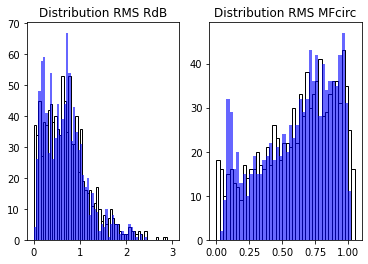

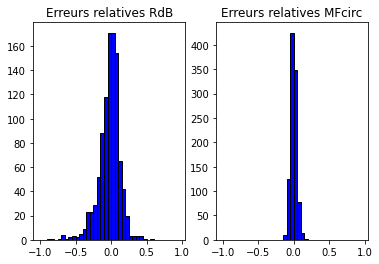

Standard deviation of RdB errors : 0.157
Standard deviation of MFcirc errors : 0.042


In [104]:
torch.cuda.empty_cache()
gc.collect()

print(torch.abs(torch.div(y_pred-y_test,y_test)).mean().item())
print(torch.abs(torch.div(y_pred-y_test,y_pred)).mean().item())

# Define RMS histogram binning
nb = 20
bins1 = np.arange(0, max(torch.max(y_test[:,0]), torch.max(y_pred[:,0])), 1/nb)
bins2 = np.arange(0, max(torch.max(y_test[:,1]), torch.max(y_pred[:,1])), 1/(2*nb))

# Plot RMS distributions
plt.subplot(1,2,1)
plt.hist(y_test[:,0], bins=bins1, color='white', edgecolor='black')
plt.hist(y_pred[:,0], bins=bins1, color='blue', alpha=0.6)
plt.title("Distribution RMS RdB")
plt.subplot(1,2,2)
plt.hist(y_test[:,1], bins=bins2, color='white', edgecolor='black')
plt.hist(y_pred[:,1], bins=bins2, color='blue', alpha=0.6)
plt.title("Distribution RMS MFcirc")
plt.show()


# Define error distributions
D_rdb = y_pred[:,0]-y_test[:,0] #torch.div(y_pred[:,0]-y_test[:,0],y_pred[:,0])
D_mfcirc = y_pred[:,1]-y_test[:,1] #torch.div(y_pred[:,1]-y_test[:,1],y_pred[:,1])

# Define error histogram binning
nb = 20
bins3 = np.arange(-1, 1, 1/nb)
bins4 = np.arange(-1, 1, 1/nb)

# Plot error distributions
plt.subplot(1,2,1)
plt.hist(D_rdb, bins=bins3, color='blue', edgecolor='black')
plt.title("Erreurs relatives RdB")
plt.subplot(1,2,2)
plt.hist(D_mfcirc, bins=bins4, color='blue', edgecolor='black')
plt.title("Erreurs relatives MFcirc")
plt.show()

# Print error std
std_rdb = torch.std(D_rdb).item()
std_mfcirc = torch.std(D_mfcirc).item()
print(f'Standard deviation of RdB errors : {std_rdb:.3f}')
print(f'Standard deviation of MFcirc errors : {std_mfcirc:.3f}')

Errors on the following block are mostly fixed by restarting it

In [105]:
# save for inference
filename = f'/content/{model_name}_{std_rdb:.3f}_{std_mfcirc:.3f}_inf.onnx' # drive/MyDrive/ 

# Input to the model
x = torch.randn(1, 3, SIZE, SIZE, requires_grad=True)

# Export the model
model.to_onnx(filename, x, export_params=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/shufflenetv2.py:30: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  channels_per_group = num_channels // groups


fatal: destination path 'map_fit' already exists and is not an empty directory.
